# Keras starter kit [full training set, UNet]

## Note

- 高い解像度でリサイズすることはprecisionの向上につながるため有効
- seresnextでチャネル間の相関を見れるので有効
- 文字の太さ・書き方に大きくバリアントがあるので、横の相関よりもdepthの相関の方が大事かもしれない
- 深さに関して、隣り合う深さ同士に大きな変化はない
- fpをfnよりも小さくしたい
- valid_scoreはCFG.thd依存
- valid_lossはCFG.loss1/loss2依存
- encoder内でdepthをクロップしてバッチで繋げた方が精度が良い
- maskに対しては有効ではないが、labelは的確なラベルを用いることで精度が向上
- depthは22~34 or 24 ~ 36
- 画像のサイズは大きい方が良いのか？（BUFFER / SHARED_HEIGHT）
    - 比率を同じにして試してみる
    - SHARED_HEIGHTをデカくするとデータがメモリに載らなさそうだった
- NetのweightsにBatchNormはない方が良い
- BUFFER:strideを160:96から160:80にしたら精度が落ちた
    - trainの精度は上がっていた
    - BUFFERに対してstrideが細かすぎると過学習に繋がっているのかもしれない
    - P.S. strideを小さくすることで、学習時のバイアスが減るので良い学習ができる
- 文字が見えなくなるよりも、高いthdを設定して、文字が大きく見えた方が良い（仮説）
- バイリニアよりもバイキュービックが良い
    - 計算コストが気になるところ
- ノイズについて
    - 大きすぎると良くない(intensityが(0.0001, 0.0005)くらいが良かった)
        - 元画像が255 * 255の範囲であることを踏まえると、1/255の変化で255のずれがある
- lossのαとβについて
    - 理論的にはαは大きい方が良い（偽陽性fpはスコアを大きく下げるので）
    - しかし、thdを用いて偽陽性を防ぐ手法もあるため、学習時にはあえて偽陰性に強いペナルティを与えた方が良いのかもしれない
    - Stacked UnetのI層目では高いβで見落としをなくして、二層目で高いαにしてノイズを除去する作戦
- 文字サイズとリサイズサイズについて
- thresholdを変えるだけでpublic lbが大きく変わる
    - 0.5から0.7にしたら0.05上がった（0.58→0.63）
- 学習時・推論時に低いRESIZED_HEIGHTで進めると、提出時にcvとlbに差が出るかもしれない。これは最終的にリサイズする際に細かい部分の見落としが発生するからだと思う
    - 良い学習をするために、正しいラベル・正しい入力が適切→resizeすることでデータの質が損なわれているのかも
- [ ] 3dcnnにbatch化したdepthを横に繋げる実装が使えるか考える
- [ ] Stacked Unetを3dcnnに適用してみる
- 解像度（BUFFER）はある程度大きくないといけない（<112）
- DecoderBlockのattention=scseについて
- 3dresnetで見る場合、最初のconv1とmaxpoolで解像度が1/4に縮小されるので、元が128x128であれば32x32をUpScaleすることになる。なので、元々ある程度高い解像度が必要
    - これは2次元encoderでも同様のことが言えるはず
- 3dresnetで見る場合、Z_LISTは2飛ばしで広く見る方が精度が高い
- ampを有効にする（precision=16）
- 3dresnetで学習時の精度が良くならない
    - 解像度が低い（仮説）
    - agumentationが難しすぎる（仮説）
        - augmentationの確率を下げても変化はなかった
        - augmentationをなくすとどうなる？
            - 減らすとtrainの精度が上がるが、valはlossが下がらない現象が発生
                - それでもtrainの精度は60%程度で停滞
- pretrainedのモデルの種類：K,KM
    - KMが有効に見える
- 3次元においてもStacked UNetは有効（以下、比較）
    - https://wandb.ai/fummicc1/lightning_logs/runs/kylnuh3w?workspace=user-fummicc1
    - https://wandb.ai/fummicc1/lightning_logs/runs/jr49frri?workspace=user-fummicc1

- augmentationを無くしたら学習時の精度は上がった
    - https://wandb.ai/fummicc1/lightning_logs/runs/rdmdfcm4?workspace=user-fummicc1
    - https://wandb.ai/fummicc1/lightning_logs/runs/ry6jtkkp?workspace=user-fummicc1
- fragment1もaとbに分割してみる（5fold）
- augmentation
    - transposeが微妙かも？
        - でも、正方形の入力画像でtransposeするのはHorizontal/VerticalのFlipと同値に感じる
    - Flip系はOK
    - なぜかPadIfNeededが検証データに対して効いている
- BCELossだと学習が不安定になった
    - https://wandb.ai/fummicc1/lightning_logs/runs/1byzvdec?workspace=user-fummicc1
    - https://wandb.ai/fummicc1/lightning_logs/runs/pmqpfwcg?workspace=user-fummicc1
- ラベルの値が0,1の場合はSoftBCEとBCEに違いはない


## Setup

In [1]:

import numpy as np
import torch
import torch.nn as nn
import wandb
import torchvision
import datetime
import imageio
# import cupy
from sklearn.model_selection import KFold
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pytorch_lightning
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
import pytorch_lightning.callbacks.model_checkpoint
import pytorch_lightning.plugins
from skimage.transform import resize as resize_ski
from pytorch_lightning.strategies.ddp import DDPStrategy
from pytorch_lightning.loggers import WandbLogger
from einops import rearrange, reduce, repeat
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.decoders.unet.decoder import UnetDecoder, DecoderBlock
from timm.models.resnet import resnet10t, resnet34d, resnet50d, resnet14t, seresnext26d_32x4d, seresnext50_32x4d
from timm.models.mvitv2 import mvitv2_base
import os
import torch.utils.data
from dataclasses import dataclass

from scipy.ndimage import distance_transform_edt

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import os,cv2
import gc
import sys
import matplotlib.patches as patches
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from IPython.display import Video

# sys.path.append("/home/fummicc1/codes/competitions/kaggle-ink-detection")
# sys.path.append("/kaggle/input/resnet3d")
from resnet3d import generate_model

pytorch_lightning.seed_everything(seed=42)
torch.set_float32_matmul_precision('high')


@dataclass
class CFG():
    # Data config
    # DATA_DIR = '/kaggle/input/vesuvius-challenge-ink-detection/'
    DATA_DIR = '/home/fummicc1/codes/competitions/kaggle-ink-detection'
    # DATA_DIR = '/home/fummicc1/codes/Kaggle/kaggle-ink-detection'
    BUFFER = 112 # Half-size of papyrus patches we'll use as model inputs
    CROP_SIZE = BUFFER * 2
    STRIDE = 112
    # Z_LIST = list(range(0, 20, 5)) + list(range(22, 34))  # Offset of slices in the z direction
    # Z_LIST = [20, 22, 24, 26] + list(range(28, 36)) + [36, 38]
    # Z_LIST = list(range(16, 48, 2))
    Z_LIST = list(range(16, 40, 2))
    # Z_LIST = list(range(0, 24, 8)) + list(range(24, 36, 2)) + list(range(36, 64, 10))
    Z_DIM = len(Z_LIST)  # Number of slices in the z direction. Max value is 64 - Z_START
    BATCH_Z_DIFF = 6
    SHARED_HEIGHT = 4800  # Max height to resize all papyrii

    # Model config
    BATCH_SIZE = 128
    
    GPU_COUNT = 4

    device = torch.device("cuda")
    threshold = 0.6
    num_workers = 8
    exp = 1e-7
    mask_padding = SHARED_HEIGHT // 40

    num_epochs = 30
    lr = 1e-3
    eta_min_lr = 1e-5
    WANDB_NOTE = "新ベースライン"
    augmentation = "augmentation: Horizontal/Vertical/RandomScale/RandomRotate90/ShiftScaleRotate/MultiChannelNoise/PadIfNeeded"
    loss1_alpha = None
    loss1_beta = None
    
    loss2a_alpha = None
    loss2a_beta = None
    
    loss1_weight = 0.5
    loss2_weight = 0.5
    
    loss2a_weight = 0.5
    loss2b_weight = 0.5
    
    lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts
    optimizer = "AdamW"
    # loss1 = smp.losses.TverskyLoss(
    #     smp.losses.BINARY_MODE,
    #     log_loss=False,
    #     from_logits=True, 
    #     smooth=1e-7,
    #     alpha=loss1_alpha,
    #     beta=loss1_beta,
    # )
    loss1 = nn.BCEWithLogitsLoss()
    # loss2a = smp.losses.TverskyLoss(
    #     smp.losses.BINARY_MODE,
    #     log_loss=False,
    #     from_logits=True, 
    #     smooth=1e-7,
    #     alpha=loss2a_alpha,
    #     beta=loss2a_beta,
    # )
    loss2a = nn.BCEWithLogitsLoss()
    loss2b = nn.BCEWithLogitsLoss()
    noise_intensity = (0.00005, 0.00025)
    use_new_label_mask = True
    pretrained = True
    # MODEL_DEPTH = 34
    # MODEL_KIND = "KM"
    
    exp_name = "038-gpu17"
    prev_exp_name = ""
    
def class2dict(c):
    return {attr: getattr(c, attr) for attr in dir(c) if not callable(getattr(c, attr)) and not attr.startswith("__")}

Global seed set to 42


## Load up the training data

In [2]:
def resize(img):
    current_height, current_width = img.shape    
    aspect_ratio = current_width / current_height
    if CFG.SHARED_HEIGHT is None:
        return img
    # new_height = CFG.SHARED_HEIGHT
    # pad_y = new_height - current_height
    # if pad_y > 0:
    #     # 元画像が小さい場合は解像度を大きくしないでpaddingをつける
    #     img = np.pad(img, [(0, pad_y), (0, 0)], constant_values=0)
    # else:
    # 既に十分でかい場合はリサイズする
    # 本当はpaddingしたいけど、メモリサイズが大きくなる
    new_height = CFG.SHARED_HEIGHT
    new_width = int(CFG.SHARED_HEIGHT * aspect_ratio)
    new_size = (new_width, new_height)
    # (W, H)の順で渡すが結果は(H, W)になっている
    img = cv2.resize(img, new_size)
    return img

def load_mask(split, index): 
    if index == "2a" or index == "2b":
        mode = index[1]
        index = "2"
    img = cv2.imread(f"{CFG.DATA_DIR}/{split}/{index}/mask.png", 0) // 255
    if index == "2":
        h = 9456
        if mode == "a":
            img = img[h:, :]
        elif mode == "b":   
            img = img[:h, :]
    img = resize(img)
    img = np.pad(img, 1, constant_values=0)
    dist = distance_transform_edt(img)
    img[dist <= CFG.mask_padding] = 0
    img = img[1:-1, 1:-1]    
    return img


def load_labels(split, index):
    if index == "2a" or index == "2b":
        mode = index[1]
        index = "2"
    suffix = "_new" if CFG.use_new_label_mask else ""
    img = cv2.imread(f"{CFG.DATA_DIR}/{split}/{index}/inklabels{suffix}.png", 0) // 255    
    if index == "2":
        h = 9456
        if mode == "a":
            img = img[h:, :]
        elif mode == "b":   
            img = img[:h, :]
    img = resize(img)
    return img

In [3]:
# input shape: (H, W, C)
def rotate90(volume: np.ndarray, k=None, reverse=False):    
    if k:
        volume = np.rot90(volume, k)
    else:
        volume = np.rot90(volume, 1 if not reverse else 3)
    height = volume.shape[0]
    width = volume.shape[1]
    new_height = CFG.SHARED_HEIGHT
    new_width = int(new_height * width / height)
    if len(volume.shape) == 2:
        return cv2.resize(volume, (new_width, new_height))
    return resize_ski(volume, (new_height, new_width, volume.shape[2]))

In [4]:
def load_volume(split, index):
    if index == "2a" or index == "2b":
        mode = index[1]
        index = "2"
    # Load the 3d x-ray scan, one slice at a time
    all = sorted(glob.glob(f"{CFG.DATA_DIR}/{split}/{index}/surface_volume/*.tif"))
    z_slices_fnames = [all[i] for i in range(len(all)) if i in CFG.Z_LIST]
    assert len(z_slices_fnames) == CFG.Z_DIM
    z_slices = []
    for z, filename in  tqdm(enumerate(z_slices_fnames)):
        img = cv2.imread(filename, -1)
        if index == "2":
            h = 9456
            if mode == "a":
                img = img[h:, :]
            elif mode == "b":
                img = img[:h, :]
        img = resize(img)
        # img = (img / (2 ** 8)).astype(np.uint8)
        img = img.astype(np.float32) // 255
        z_slices.append(img)
    return np.stack(z_slices, axis=-1)

## Create a dataset in the input volume


In [5]:
def is_in_masked_zone(location, mask):
    return mask[location[0], location[1]] > 0


In [6]:
def generate_locations_ds(volume, mask, label=None, skip_zero=False):
    is_in_mask_train = lambda x: is_in_masked_zone(x, mask)

    # Create a list to store train locations
    locations = []

    # Generate train locations
    volume_height, volume_width = volume.shape[:-1]

    for y in range(CFG.BUFFER, volume_height - CFG.BUFFER, CFG.STRIDE):
        for x in range(CFG.BUFFER, volume_width - CFG.BUFFER, CFG.STRIDE):
            if skip_zero and label is not None and np.all(label[y - CFG.STRIDE : y + CFG.STRIDE, x - CFG.STRIDE : x + CFG.STRIDE] == 0):
                # print(f"skip location at (y: {y}, x: {x})")
                continue
            if is_in_mask_train((y, x)):
                locations.append((y, x))

    # Convert the list of train locations to a PyTorch tensor
    locations_ds = np.stack(locations, axis=0)
    return locations_ds

## Visualize some training patches

Sanity check visually that our patches are where they should be.

In [7]:
def extract_subvolume(location, volume):
    global printed
    y = location[0]
    x = location[1]
    subvolume = volume[y-CFG.BUFFER:y+CFG.BUFFER, x-CFG.BUFFER:x+CFG.BUFFER, :].astype(np.float32)
    
    return subvolume

## SubvolumeDataset

In [8]:
import numpy as np
from albumentations.core.transforms_interface import ImageOnlyTransform

class MultichannelNoise(ImageOnlyTransform):

    def __init__(self, intensity=CFG.noise_intensity, always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.intensity = intensity

    def apply(self, img, **params):
        intensity = np.random.uniform(*self.intensity)
        noise = np.random.normal(loc=0, scale=intensity*255, size=img.shape)
        img = img + noise
        return np.clip(img, 0, 255).astype(np.float32) # クリップして0から255の範囲に保つ


In [9]:
def smooth_labels(labels, alpha=0.1):
    labels = labels * (1 - alpha) + alpha * 0.5
    return labels

In [10]:

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder

from albumentations.core.transforms_interface import ImageOnlyTransform

class SubvolumeDataset(Dataset):
    def __init__(self, locations, volume, labels, buffer, is_train: bool, return_location: bool = False):
        self.locations = locations
        self.volume = volume
        self.labels = labels        
        self.buffer = buffer
        self.is_train = is_train
        self.return_location = return_location

    def __len__(self):
        return len(self.locations)

    def __getitem__(self, idx):
        label = None
        location = np.array(self.locations[idx])
        y, x = location[0], location[1]

        subvolume = extract_subvolume(location, self.volume)
        
        if self.labels is not None:
            label = self.labels[y - self.buffer:y + self.buffer, x - self.buffer:x + self.buffer]            
            label = np.stack([label], axis=-1)            
            
        # 段々meanは小さくなる
        mean = np.array([0.45 - i / 200 for i in range(0, CFG.Z_DIM)]).reshape(-1, 1, 1)
        # 段々stdは小さくなる
        std = np.array([0.25 for i in range(0, CFG.Z_DIM)]).reshape(-1, 1, 1)
        
        if self.is_train and label is not None:    
            # label = smooth_labels(label, alpha=0.1)      
            transformed = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),                
                A.RandomScale(p=0.4, scale_limit=0.3),
                A.Transpose(p=0.5), 
                A.RandomRotate90(p=0.4,),            
                A.ShiftScaleRotate(p=0.8, scale_limit=0.3, rotate_limit=80),
                A.GridDistortion(num_steps=5, distort_limit=0.15, p=0.4),
                # A.CoarseDropout(
                #     max_holes=1, 
                #     max_width=int(CFG.BUFFER * 2 * 0.3),
                #     max_height=int(CFG.BUFFER * 2 * 0.3), 
                #     mask_fill_value=0, 
                #     p=0.3,
                # ),
                MultichannelNoise(
                    p=0.15,
                ),
                A.PadIfNeeded(min_height=self.buffer * 2, min_width=self.buffer * 2),
                A.Resize(height=self.buffer * 2, width=self.buffer * 2),
            ])(image=subvolume, mask=label)
            subvolume = transformed["image"]
            label = transformed["mask"]
            subvolume = np.transpose(subvolume, (2, 0, 1))
            label = np.transpose(label, (2, 0, 1))
            subvolume /= 255.
            subvolume = (subvolume - mean) / std       
        else:
            if label is None:
                subvolume = np.transpose(subvolume, (2, 0, 1))
                subvolume /= 255.
                subvolume = (subvolume - mean) / std
            else:
                # print("subvolume in val dataset (before aug)", subvolume, file=open("before-val-aug.log", "w")) 
                subvolume = np.transpose(subvolume, (2, 0, 1))
                label = np.transpose(label, (2, 0, 1))
                subvolume /= 255.
                subvolume = (subvolume - mean) / std
        # print("subvolume", subvolume)
        if self.return_location:
            return subvolume, location
        return subvolume, label        

## Visualize validation dataset patches

Note that they are partially overlapping, since the stride is half the patch size.

In [11]:
def visualize_dataset_patches(locations_ds, labels, mode: str, fold = 0):
    fig, ax = plt.subplots()
    ax.imshow(labels)

    for y, x in locations_ds:
        patch = patches.Rectangle([x - CFG.BUFFER, y - CFG.BUFFER], 2 * CFG.BUFFER, 2 * CFG.BUFFER, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(patch)
    plt.savefig(f"fold-{fold}-{mode}.png")
    plt.show()    

## Compute a trivial baseline

This is the highest validation score you can reach without looking at the inputs.
The model can be considered to have statistical power only if it can beat this baseline.

## Dataset check

## Model

In [12]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

In [13]:
class SmpUnetDecoder(nn.Module):
	def __init__(
		self,
		in_channel,
		skip_channel,
		out_channel,
	):
		super().__init__()
		self.center = nn.Identity()

		i_channel = [
			in_channel,
		] + out_channel[:-1]
		s_channel = skip_channel
		o_channel = out_channel
		# print("i:", i_channel)
		# print("s:", s_channel)
		# print("o:", o_channel)
		block = [
			DecoderBlock(i, s, o, use_batchnorm=True, attention_type=None)
			for i, s, o in zip(i_channel, s_channel, o_channel)
		]
		self.block = nn.ModuleList(block)

	def forward(self, feature, skip):
		# for s in skip:
			# print("feature", feature.shape, "skip", s.shape)
		d = self.center(feature)
		decode = []
		for i, block in enumerate(self.block):
			s = skip[i]
			d = block(d, s)
			decode.append(d)

		last = d
		return last, decode


class Net(nn.Module):
	def __init__(
		self,
	):
		super().__init__()
		self.output_type = ["inference", "loss"]

		conv_dim = 64
		encoder1_dim = [
			conv_dim,
			256,
			512,
			1024,
			2048,
		]
		decoder1_dim = [
			1024,
			512,
			256,
			64,
		]

		self.encoder1 = seresnext26d_32x4d(pretrained=CFG.pretrained, in_chans=CFG.Z_DIM - CFG.BATCH_Z_DIFF)

		self.decoder1 = SmpUnetDecoder(
			in_channel=encoder1_dim[-1],
			skip_channel=encoder1_dim[:-1][::-1],
			out_channel=decoder1_dim,
		)
		# -- pool attention weight  
		self.weight1 = nn.ModuleList(
			[
				nn.Sequential(
					nn.Conv2d(dim, dim, kernel_size=3, padding=1),
					nn.BatchNorm2d(dim),
					nn.ReLU(inplace=True),
				)
				for dim in encoder1_dim
			]
		)
		self.logit1 = nn.Conv2d(decoder1_dim[-1], 1, kernel_size=1)

		# --------------------------------
		#
		encoder2_dim = [64, 128, 256, 512]  #
		decoder2_dim = [
			256,
			128,
			64,
		]
		self.encoder2 = resnet10t(pretrained=CFG.pretrained, in_chans=decoder1_dim[-1])

		self.decoder2 = SmpUnetDecoder(
			in_channel=encoder2_dim[-1],
			skip_channel=encoder2_dim[:-1][::-1],
			out_channel=decoder2_dim,
		)
		self.logit2 = nn.Conv2d(decoder2_dim[-1], 1, kernel_size=1)

	def forward(self, batch):
		v = batch
		B, C, H, W = v.shape
		vv = [
			v[:, i : i + CFG.Z_DIM - CFG.BATCH_Z_DIFF]
			for i in range(0, CFG.BATCH_Z_DIFF + 1, 2)
		]
		K = len(vv)
		x = torch.cat(vv, 0)
		# x = v

		# ----------------------
		encoder = []
		e = self.encoder1
		x = e.conv1(x)
		x = e.bn1(x)
		x = e.act1(x)
		encoder.append(x)
		x = F.avg_pool2d(x, kernel_size=2, stride=2)
		x = e.layer1(x)
		encoder.append(x)
		x = e.layer2(x)
		encoder.append(x)
		x = e.layer3(x)
		encoder.append(x)
		x = e.layer4(x)
		encoder.append(x)
		# print('encoder', [f.shape for f in encoder])

		for i in range(len(encoder)):
			e = encoder[i]
			# e = F.avg_pool2d(e, 4, 4)
			f = self.weight1[i](e)
			_, c, h, w = e.shape
			f = rearrange(f, "(K B) c h w -> B K c h w", K=K, B=B, h=h, w=w)  #
			e = rearrange(e, "(K B) c h w -> B K c h w", K=K, B=B, h=h, w=w)  #
			w = F.softmax(f, 1)
			e = (w * e).sum(1)
			encoder[i] = e

		feature = encoder[-1]
		skip = encoder[:-1][::-1]
		# print('encoder after weighted', [f.shape for f in encoder])
		# print('skip after weighted', [f.shape for f in skip])
		last, decoder = self.decoder1(feature, skip)
		logit1 = self.logit1(last)
		# print("logit1.shape", logit1.shape)
		# print("encoder1 shapes", list(map(lambda a: a.shape, encoder)))
  
		logit1 = F.interpolate(
			logit1, size=(H, W), mode="bilinear", align_corners=False, antialias=True
		)

		# ----------------------
		x = last  # .detach()
		# x = F.avg_pool2d(x,kernel_size=2,stride=2)
		encoder = []
		e = self.encoder2
		x = e.layer1(x)
		encoder.append(x)
		x = e.layer2(x)
		encoder.append(x)
		x = e.layer3(x)
		encoder.append(x)
		x = e.layer4(x)
		encoder.append(x)

		feature = encoder[-1]
		skip = encoder[:-1][::-1]
		last, decoder = self.decoder2(feature, skip)
		logit2 = self.logit2(last)
		# print("logit2.shape", logit2.shape)
		logit2 = F.interpolate(
			logit2, size=(H, W), mode="bilinear", align_corners=False, antialias=True
		)
		return logit1, logit2


In [14]:
net_check_input = torch.from_numpy(np.random.randn(12, CFG.Z_DIM, 128, 128).astype(np.float32))
out = Net()(net_check_input)

In [15]:
tc = torch
def TTA(x:tc.Tensor,model:nn.Module):
    #x.shape=(batch,c,h,w)
    shape=x.shape
    x=[x,*[tc.rot90(x,k=i,dims=(-2,-1)) for i in range(1,4)]]
    x=tc.cat(x,dim=0)
    _, x = model(x)
    x=x.reshape(4,shape[0], 1 ,*shape[2:])
    x=[tc.rot90(x[i],k=-i,dims=(-2,-1)) for i in range(4)]
    x=tc.stack(x,dim=0)
    return x.mean(0)

In [16]:


class Model(pl.LightningModule):
    training_step_outputs = []
    validation_step_outputs = []
    test_step_outputs = [[], []]

    def __init__(self, **kwargs):
        super().__init__()

        self.model = Net()        

        self.loss1 = CFG.loss1
        self.loss2 = CFG.loss2a
        self.loss3 = CFG.loss2b

    def forward(self, image, stage):
        if stage != "train":
            mask = TTA(image, self.model)
            # mask = self.model(image)
        else:
            mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        subvolumes, labels = batch

        image, labels = subvolumes.float(), labels.float()        
        assert image.ndim == 4
        
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0
        
        # print("labels", labels.max(), labels.min())

        assert labels.max() <= 1.0 and labels.min() >= 0

        if stage == "train":
            logit1, logit2 = self.forward(image, stage)
            loss = self.loss1(logit1, labels) * CFG.loss1_weight + CFG.loss2_weight * (self.loss2(logit2, labels) * CFG.loss2a_weight + self.loss3(logit2, labels) * CFG.loss2b_weight)
            logit = logit2
        else:
            logit = self.forward(image, stage)
            loss = self.loss2(logit, labels) * CFG.loss2a_weight + self.loss3(logit, labels) * CFG.loss2b_weight
        
        prob2 = torch.sigmoid(logit)

        pred_mask = (prob2 > CFG.threshold).float()
        
        # print("pred_mask", pred_mask)
        
        score = fbeta_score(pred_mask, labels, threshold=CFG.threshold)

        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), labels.long(), mode="binary"
        )

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
            "score": score,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])
        loss = torch.mean(torch.Tensor([x["loss"] for x in outputs]))
        fbeta_score = torch.mean(torch.Tensor([x["score"] for x in outputs]))

        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_loss": 10000 if loss.item() == 0 else loss.item(),
            f"{stage}_tp": tp.sum().int().item(),
            f"{stage}_fp": fp.sum().int().item(),
            f"{stage}_fn": fn.sum().int().item(),
            f"{stage}_tn": tn.sum().int().item(),
            f"{stage}_score": fbeta_score.item(),
        }

        self.log_dict(metrics, prog_bar=True, sync_dist=True)

    def training_step(self, batch, batch_idx):
        out = self.shared_step(batch, "train")
        self.training_step_outputs.append(out)
        return out

    def on_train_epoch_end(self):
        out = self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()
        return out

    def validation_step(self, batch, batch_idx):
        out = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(out)
        return out

    def on_validation_epoch_end(self):
        out = self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return out

    def test_step(self, batch, batch_idx):
        global predictions_map, predictions_map_counts

        patch_batch, loc_batch = batch

        loc_batch = loc_batch.long()
        patch_batch = patch_batch.float()
        predictions = self.forward(patch_batch, "test")
        predictions = predictions.sigmoid()
 
        predictions = torch.permute(predictions, (0, 2, 3, 1)).squeeze(dim=-1)
        predictions = (
            predictions.cpu().numpy()
        )
        loc_batch = loc_batch.cpu().numpy()
        
        self.test_step_outputs[0].extend(loc_batch)
        self.test_step_outputs[1].extend(predictions)        
        return loc_batch, predictions

    def on_test_epoch_end(self):
        global predictions_map, predictions_map_counts

        locs = np.array(self.test_step_outputs[0])
        preds = np.array(self.test_step_outputs[1])
        print("locs", locs.shape)
        print("preds", preds.shape)


        for (y, x), pred in zip(locs, preds):
            predictions_map[
                y - CFG.BUFFER : y + CFG.BUFFER, x - CFG.BUFFER : x + CFG.BUFFER
            ] += pred
            predictions_map_counts[
                y - CFG.BUFFER : y + CFG.BUFFER, x - CFG.BUFFER : x + CFG.BUFFER
            ] += 1
        
        predictions_map /= predictions_map_counts + CFG.exp

    def configure_optimizers(self):
        # optimizer = optim.SGD(self.parameters(), lr=CFG.lr)
        optimizer = optim.AdamW(self.parameters(), lr=CFG.lr)

        scheduler = CFG.lr_scheduler(
            optimizer, T_0=CFG.num_epochs, T_mult=2, eta_min=CFG.eta_min_lr,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
        }

Global seed set to 42


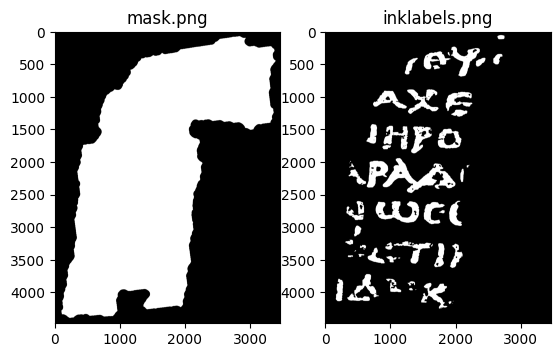

mask_test_a: (4480, 10399)
mask_test_b: (4480, 5199)
-
mask_train_1: (4480, 3466)
labels_train_1: (4480, 3466)
-
mask_train_2a: (4480, 7924)
labels_train_2a: (4480, 7924)
-
mask_train_2b: (4480, 4503)
labels_train_2b: (4480, 4503)
-
mask_train_3: (4480, 3091)
labels_train_3: (4480, 3091)


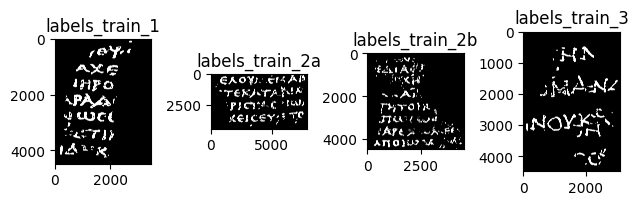

12it [00:03,  3.12it/s]


volume_train_1: (4480, 3466, 12), float32


12it [00:10,  1.11it/s]


volume_train_2a: (4480, 7924, 12), float32


12it [00:06,  1.87it/s]


volume_train_2b: (4480, 4503, 12), float32


12it [00:03,  3.45it/s]


volume_train_3: (4480, 3091, 12), float32


In [17]:
pytorch_lightning.seed_everything(seed=42)
torch.set_float32_matmul_precision('high')


masks = load_mask(split="train", index=1)
labels = load_labels(split="train", index=1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(masks, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(labels, cmap='gray')
plt.show()

mask_test_a = load_mask(split="test", index="a")
mask_test_b = load_mask(split="test", index="b")

mask_train_1 = load_mask(split="train", index="1")
labels_train_1 = load_labels(split="train", index="1")

mask_train_2a = load_mask(split="train", index="2a")
labels_train_2a = load_labels(split="train", index="2a")

mask_train_2b = load_mask(split="train", index="2b")
labels_train_2b = load_labels(split="train", index="2b")

mask_train_3 = load_mask(split="train", index="3")
labels_train_3 = load_labels(split="train", index="3")

print(f"mask_test_a: {mask_test_a.shape}")
print(f"mask_test_b: {mask_test_b.shape}")
print("-")
print(f"mask_train_1: {mask_train_1.shape}")
print(f"labels_train_1: {labels_train_1.shape}")
print("-")
print(f"mask_train_2a: {mask_train_2a.shape}")
print(f"labels_train_2a: {labels_train_2a.shape}")
print("-")
print(f"mask_train_2b: {mask_train_2b.shape}")
print(f"labels_train_2b: {labels_train_2b.shape}")
print("-")
print(f"mask_train_3: {mask_train_3.shape}")
print(f"labels_train_3: {labels_train_3.shape}")

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

ax1.set_title("labels_train_1")
ax1.imshow(labels_train_1, cmap='gray')

ax2.set_title("labels_train_2a")
ax2.imshow(labels_train_2a, cmap='gray')

ax3.set_title("labels_train_2b")
ax3.imshow(labels_train_2b, cmap='gray')

ax4.set_title("labels_train_3")
ax4.imshow(labels_train_3, cmap='gray')
plt.tight_layout()
plt.show()

volume_train_1 = load_volume(split="train", index=1)
print(f"volume_train_1: {volume_train_1.shape}, {volume_train_1.dtype}")

volume_train_2a = load_volume(split="train", index="2a")
print(f"volume_train_2a: {volume_train_2a.shape}, {volume_train_2a.dtype}")

volume_train_2b = load_volume(split="train", index="2b")
print(f"volume_train_2b: {volume_train_2b.shape}, {volume_train_2b.dtype}")

volume_train_3 = load_volume(split="train", index=3)
print(f"volume_train_3: {volume_train_3.shape}, {volume_train_3.dtype}")

# volume = np.concatenate([volume_train_1, volume_train_2, volume_train_3], axis=1)
# volume = np.concatenate([volume_train_1, volume_train_2], axis=1)
# print(f"total volume: {volume.shape}")

In [18]:
sample_data_name = "2a"
sample_volume = load_volume("train", sample_data_name)
sample_mask = load_mask("train", sample_data_name)
sample_label = load_labels("train", sample_data_name)
sample_locations = generate_locations_ds(sample_volume, sample_mask, sample_label, skip_zero=True)

12it [00:10,  1.14it/s]


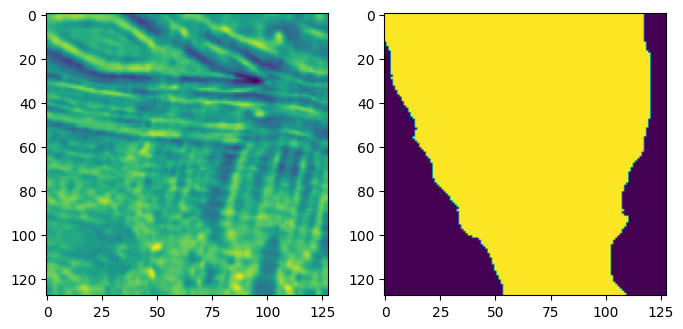

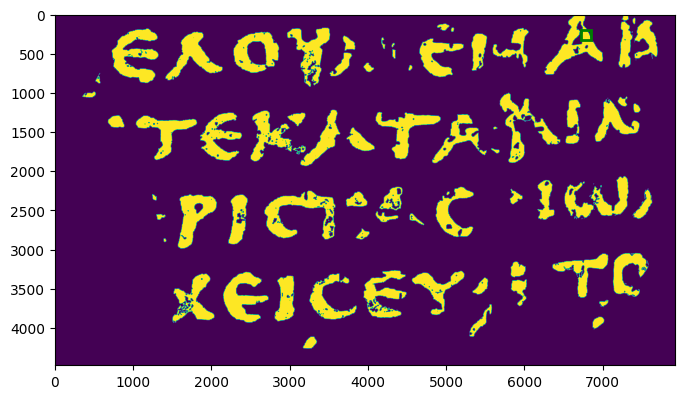

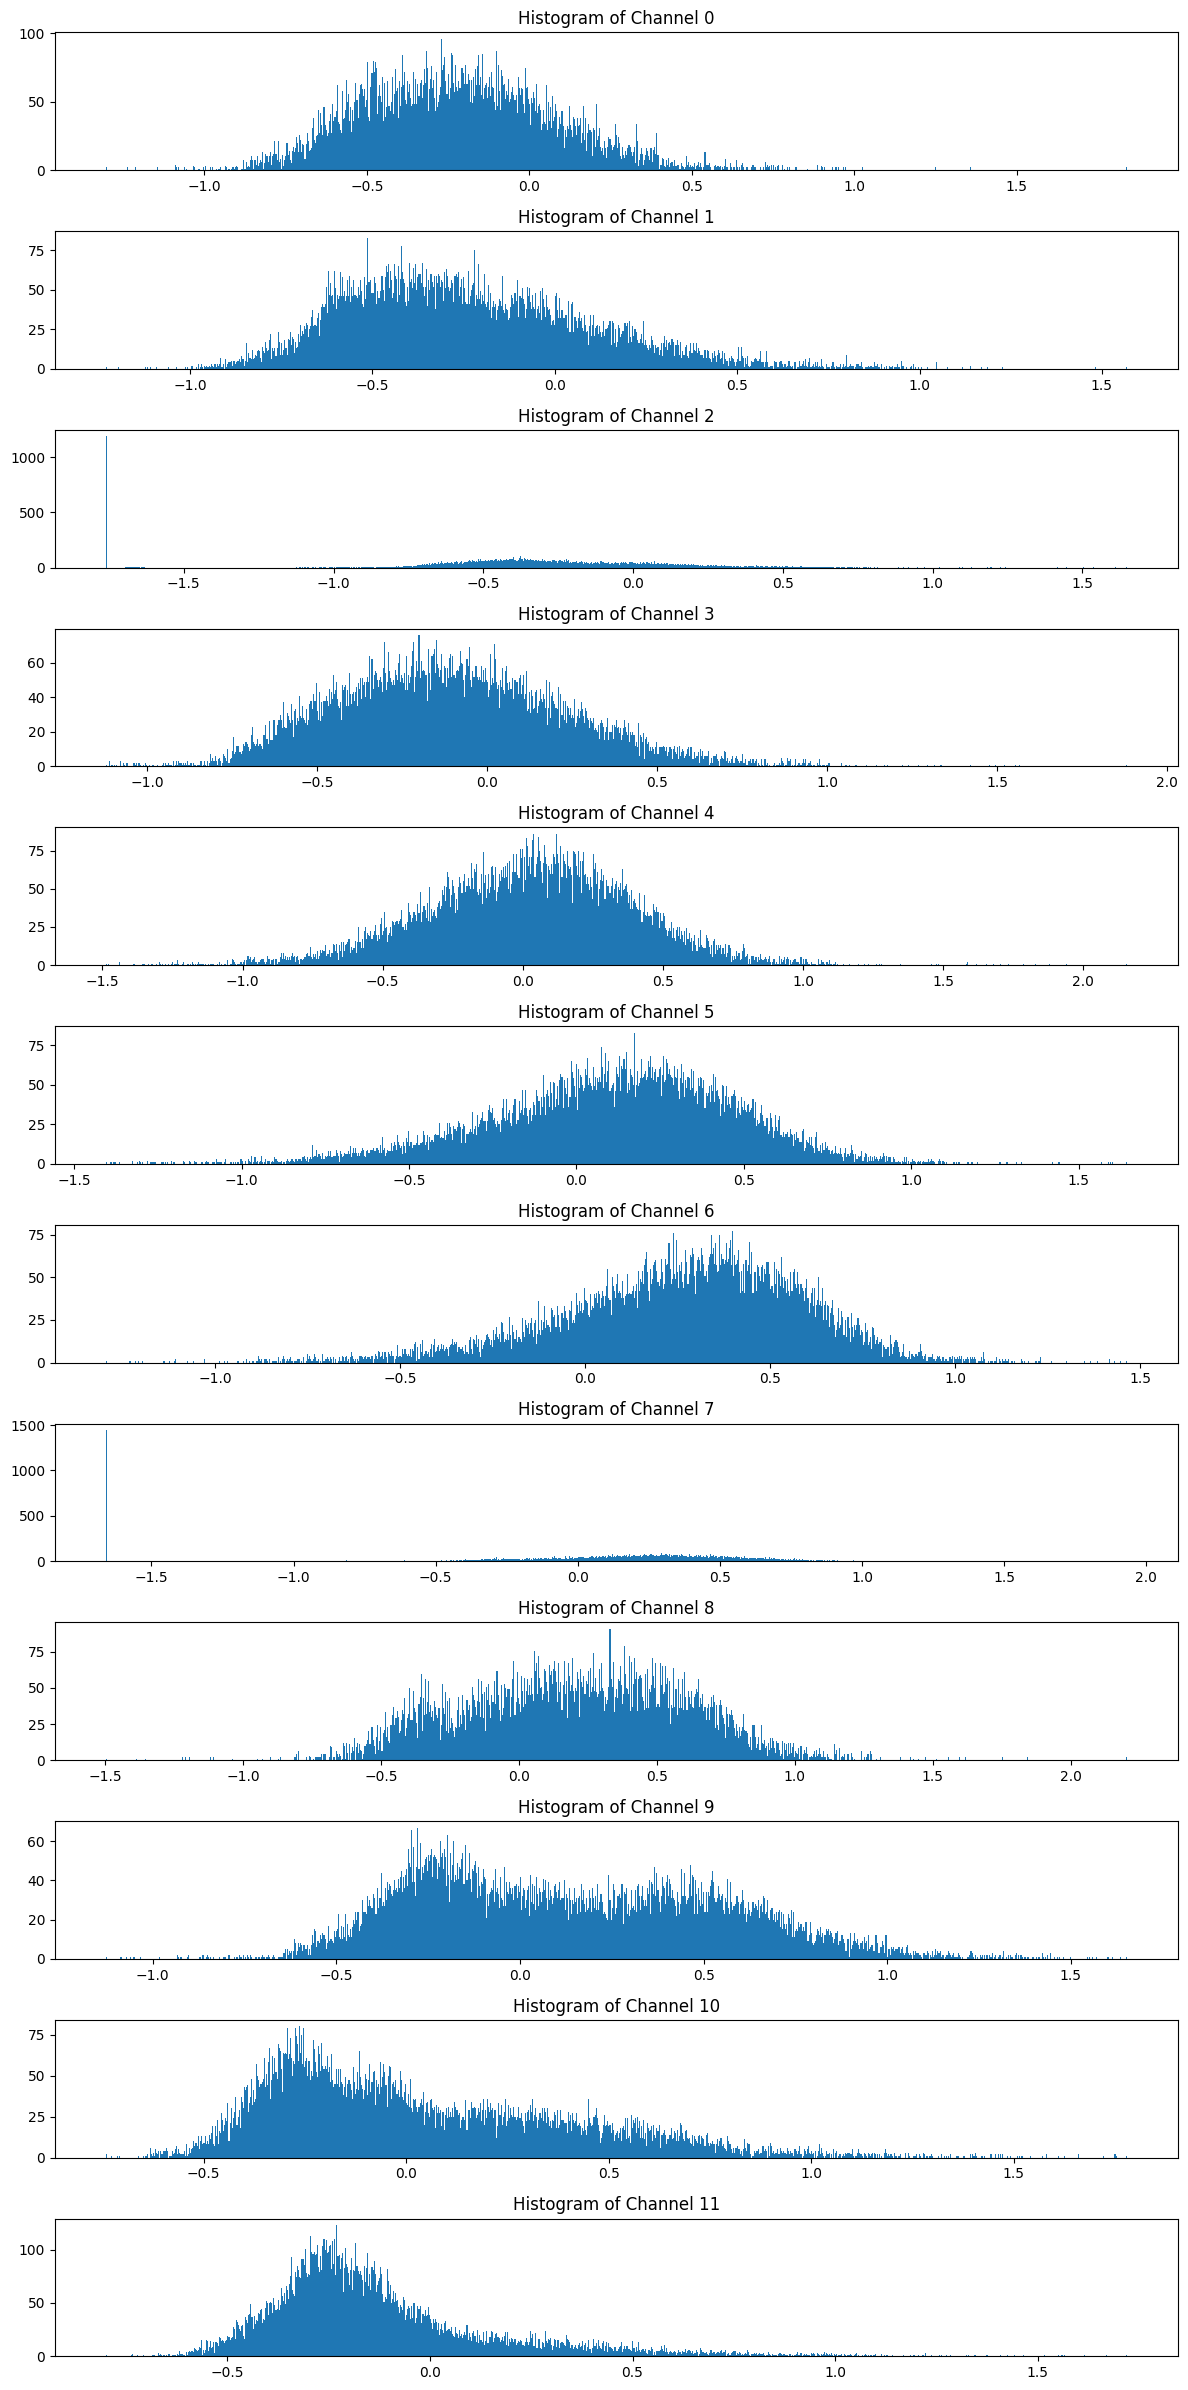

In [19]:
sample_ds = SubvolumeDataset(
    sample_locations,
    sample_volume,
    sample_label,
    CFG.BUFFER,
    is_train=True,
)

id = 100
sample_depth = CFG.Z_DIM // 2

fig, ax = plt.subplots(1, 2, figsize=(8, 6))

img = sample_ds[id][0][sample_depth, :, :]
label = sample_ds[id][1][0, :, :]
ax[0].imshow(img)
ax[1].imshow(label)

fig, ax = plt.subplots(figsize=(8, 6))

ax.imshow(sample_label)

y, x = sample_locations[id]
patch = patches.Rectangle([x - CFG.BUFFER, y - CFG.BUFFER], 2 * CFG.BUFFER, 2 * CFG.BUFFER, linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(patch)
plt.show()    

fig, ax = plt.subplots(CFG.Z_DIM, 1, figsize=(12, 24))

for i in range(CFG.Z_DIM):
    img, _ = sample_ds[id]
    img = img[i, :, :]
    ax[i].hist(img.flatten(), bins=1000)  # Plot histogram of the flattened data
    ax[i].set_title(f"Histogram of Channel {i}")  # Add title to the plot    
fig.tight_layout()
fig.show()

FOLD 0
--------------------------------
train_data [1 2 3]
val_data [0]


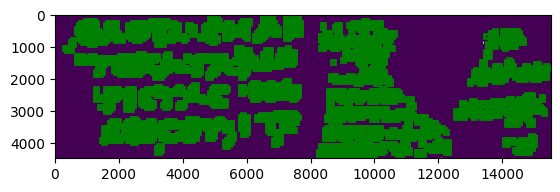

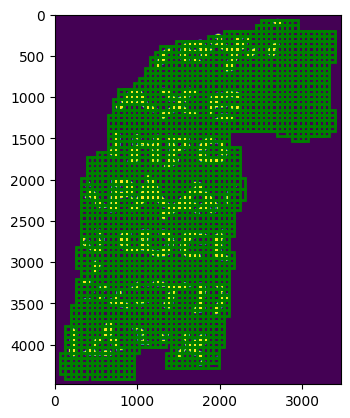

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: fummicc1. Use `wandb login --relogin` to force relogin


/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/ ...
  rank_zero_warn(
Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/ ...
  rank_zero

Sanity Checking: 0it [00:00, ?it/s]

/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:208: UserWarning: num_workers>0, persistent_workers=False, and strategy=ddp_spawn may result in data loading bottlenecks. Consider setting persistent_workers=True (this is a limitation of Python .spawn() and PyTorch)
  rank_zero_warn(
/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('valid_tp', ...)` in your `on_validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('valid_fp', ...)` in your `on_validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('train_tp', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('train_fp', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('train_fn', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/fummicc1/anaconda3/envs/ink-

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


FOLD 1
--------------------------------
train_data [0 2 3]
val_data [1]


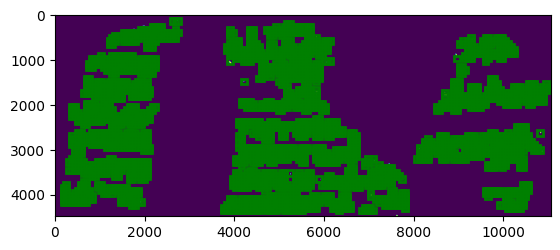

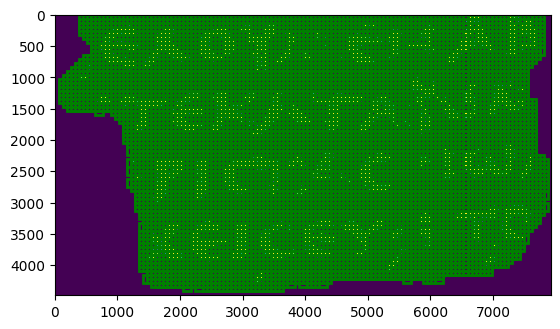

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_dataset_iou,▁▃▃▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████████
train_fn,█▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_fp,▂▇██▇▇▇▆█▆▆▆▆▅▄▄▅▄▄▃▃▃▂▂▂▁▂▁▁▁
train_loss,█▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
train_per_image_iou,▁▃▄▄▄▅▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇████████
train_score,▁▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████████
train_tn,▇▂▁▁▂▁▂▃▁▃▃▃▃▄▅▅▄▅▅▆▆▆▇▇▆█▇███
train_tp,▁▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██████████
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
valid_dataset_iou,▁▁▆▂█▂▇▄▆▇▆▆▇▇▅▇▆▇▇█▇▆▇▆▇▇▆▇▆▇


/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/ ...
  rank_zero_warn(
Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 

Sanity Checking: 0it [00:00, ?it/s]

/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:208: UserWarning: num_workers>0, persistent_workers=False, and strategy=ddp_spawn may result in data loading bottlenecks. Consider setting persistent_workers=True (this is a limitation of Python .spawn() and PyTorch)
  rank_zero_warn(
/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('valid_tp', ...)` in your `on_validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('valid_fp', ...)` in your `on_validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('train_tp', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('train_fp', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('train_fn', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/fummicc1/anaconda3/envs/ink-

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


FOLD 2
--------------------------------
train_data [0 1 3]
val_data [2]


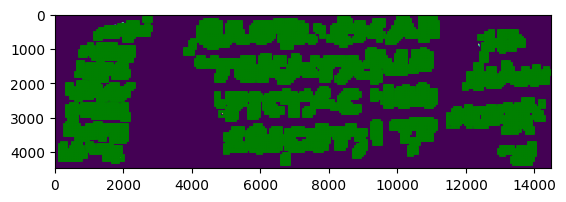

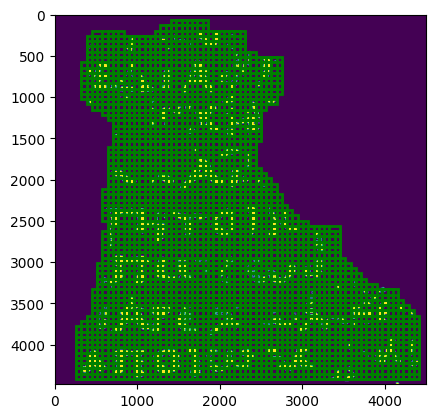

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_dataset_iou,▁▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████████
train_fn,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
train_fp,▁▆▇███▇▇█▆▇▇▆▇▆▆▆▆▆▆▅▆▆▅▅▅▅▅▅▅
train_loss,█▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_per_image_iou,▁▃▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████████
train_score,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████
train_tn,█▃▂▁▁▁▂▂▁▃▂▂▃▂▂▃▃▃▃▃▄▃▃▄▄▄▄▄▄▄
train_tp,▁▃▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█▇█████████
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
valid_dataset_iou,▅▂▁▂▅▃▂▂▂▇▅▂▆▅▇▇███▅█▇█▇▇▇█▇▇▇


/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/ ...
  rank_zero_warn(
Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 

Sanity Checking: 0it [00:00, ?it/s]

/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:208: UserWarning: num_workers>0, persistent_workers=False, and strategy=ddp_spawn may result in data loading bottlenecks. Consider setting persistent_workers=True (this is a limitation of Python .spawn() and PyTorch)
  rank_zero_warn(
/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('valid_tp', ...)` in your `on_validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('valid_fp', ...)` in your `on_validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('train_tp', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('train_fp', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('train_fn', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/fummicc1/anaconda3/envs/ink-

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


FOLD 3
--------------------------------
train_data [0 1 2]
val_data [3]


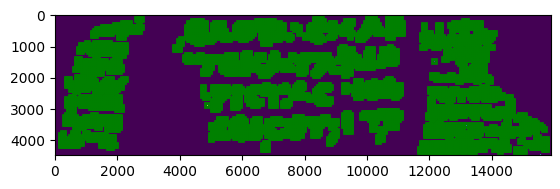

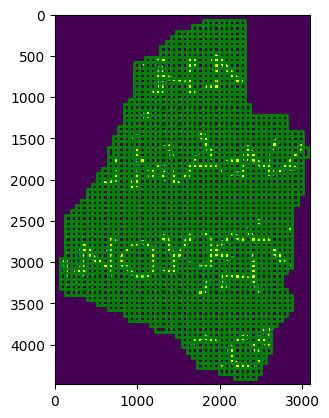

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_dataset_iou,▁▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████
train_fn,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_fp,▁▅█▆▇▇▅▇▇▆▆▅▆▅▅▄▅▃▄▃▃▃▂▃▂▂▂▂▂▂
train_loss,█▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
train_per_image_iou,▁▃▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████
train_score,▁▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████████
train_tn,█▄▁▃▂▂▄▂▂▃▃▄▄▄▄▄▄▅▅▆▆▆▇▆▇▇▇▇▇▇
train_tp,▁▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████████
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
valid_dataset_iou,▁▂▆▆▇█▇▅███▆▇▆▆▇█▇▇█▆██▇▇▇▇▇▇▇


/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/ ...
  rank_zero_warn(
Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 

Sanity Checking: 0it [00:00, ?it/s]

/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:208: UserWarning: num_workers>0, persistent_workers=False, and strategy=ddp_spawn may result in data loading bottlenecks. Consider setting persistent_workers=True (this is a limitation of Python .spawn() and PyTorch)
  rank_zero_warn(
/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('valid_tp', ...)` in your `on_validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('valid_fp', ...)` in your `on_validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('train_tp', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('train_fp', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('train_fn', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/fummicc1/anaconda3/envs/ink-

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_dataset_iou,▁▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████████
train_fn,█▆▆▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_fp,▁▆▆█▆█▇▇▇▅▇▅▆▄▆▄▃▃▄▄▂▃▂▂▂▂▂▁▁▁
train_loss,█▇▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
train_per_image_iou,▁▃▃▄▅▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇█████████
train_score,▁▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████████
train_tn,█▃▃▁▃▁▁▂▂▄▁▄▃▄▃▅▆▆▅▅▇▅▇▇▇▇▇███
train_tp,▁▃▃▄▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇█████████
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
valid_dataset_iou,▁▁▆▅▆▄▆▆██▇█▇▆█▇██▇▇█▇▇▇▇▇▇▇▇▇


In [20]:

k_folds = 4
kfold = KFold(
    n_splits=k_folds,
)

data_list = [    
    (volume_train_1, labels_train_1, mask_train_1),
    (volume_train_2a, labels_train_2a, mask_train_2a),    
    (volume_train_2b, labels_train_2b, mask_train_2b),
    (volume_train_3, labels_train_3, mask_train_3),    
]

predictions_map = None
predictions_map_counts = None

for fold, (train_data, val_data) in enumerate(kfold.split(data_list)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    print("train_data", train_data)
    print("val_data", val_data)
    one = data_list[train_data[0]]
    two = data_list[train_data[1]]
    three = data_list[train_data[2]]
    train_volume = np.concatenate([one[0], two[0], three[0]], axis=1)
    train_label = np.concatenate([one[1], two[1], three[1]], axis=1)
    train_mask = np.concatenate([one[2], two[2], three[2]], axis=1)
    val_volume, val_label, val_mask = data_list[val_data[0]]    

    train_locations_ds = generate_locations_ds(train_volume, train_mask, train_label, skip_zero=True)
    val_location_ds = generate_locations_ds(val_volume, val_mask, skip_zero=False)

    visualize_dataset_patches(train_locations_ds, train_label, "train", fold)
    visualize_dataset_patches(val_location_ds, val_label, "val", fold)
    
    # Init the neural network
    model = Model()

    wandb.finish()
    # Initialize a trainer
    now = datetime.datetime.now()
    now = f"{now}".replace(" ", "")
    
    checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
        monitor='valid_score',
        dirpath=f'best-results-{now}/',
        mode="max",
        filename='train-fold-' + str(fold) + '-{epoch:02d}-{valid_score:.3f}',
        save_last=True,
    )
    
    trainer = pl.Trainer(
        max_epochs=CFG.num_epochs,
        devices="0,1,2,3",
        accelerator="gpu",
        precision=16,
        # strategy="ddp_find_unused_parameters_false",
        # strategy="ddp_fork",
        logger=WandbLogger(
            name=f"2.5dimension-{now}-fold-{fold}-val-{val_data[0]}",
            notes=CFG.WANDB_NOTE,
            config=class2dict(CFG()),
        ),
        callbacks=[checkpoint_callback],
        default_root_dir=os.path.join(CFG.DATA_DIR, f"{now}-fold-{fold}-val-{val_data[0]}"),
    )
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_ds = SubvolumeDataset(
        train_locations_ds,
        train_volume,
        train_label,
        CFG.BUFFER,
        is_train=True
    )
    val_ds = SubvolumeDataset(
        val_location_ds,
        val_volume,
        val_label,
        CFG.BUFFER,
        is_train=False,
    )

    # Define data loaders for training and testing data in this fold
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG.BATCH_SIZE,
        num_workers=CFG.num_workers,
        shuffle=True,
        # persistent_workers=True,
        # pin_memory=True,
    )
    val_loader = torch.utils.data.DataLoader(
        val_ds, 
        batch_size=CFG.BATCH_SIZE,
        num_workers=CFG.num_workers,
        shuffle=False,
        # pin_memory=True,
        # persistent_workers=True,
    )

    # Train the model
    trainer.fit(model, train_loader, val_loader)   

    # if trainer.global_rank == 0:
    #     val_ds = SubvolumeDataset(
    #         val_location_ds,
    #         val_volume,
    #         val_label,
    #         CFG.BUFFER,
    #         is_train=False,
    #         return_location=True,
    #     )
    #     val_loader = torch.utils.data.DataLoader(
    #         val_ds, 
    #         batch_size=CFG.BATCH_SIZE,
    #         num_workers=CFG.num_workers,
    #         shuffle=False,
    #         # pin_memory=True,
    #         # persistent_workers=True,
    #     )
        
    #     test_trainer = pl.Trainer(
    #         devices="1",
    #         accelerator="gpu",
    #     )

    #     predictions_map = np.zeros_like(val_volume[:, :, 0]).astype(np.float64)
    #     predictions_map_counts = np.zeros_like(predictions_map).astype(np.uint8)
        
    #     test_model = Model.load_from_checkpoint(
    #         f'best-results-{now}/' + "last.ckpt"
    #     )

    #     test_trainer.test(
    #         model=test_model,
    #         dataloaders=val_loader,
    #         verbose=True,
    #     )
        
    #     print("predictions_map.shape", predictions_map.shape)
    #     predictions_map = np.where(predictions_map >= CFG.threshold, 255, 0)
    #     plt.imsave(f"2.5dimension-{now}-fold-{fold}-thd-{str(CFG.threshold)}_{str(CFG.BUFFER)}.png", predictions_map, cmap="gray")        

wandb.finish()
